<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# RAG with LLM-Based Evaluation Metrics

This notebook demonstrates how to perform Retrieval Augmented Generation (RAG) with Auto-Evaluation using LLM-based Metrics.

The metrics we will consider are:
1. **Context precision**: How well the retrieved context aligns with the user query
2. **Answer relevancy**: How effectively the response addresses the user query
3. **Faithfulness**: How accurately the generated response reflects the retrieved documents

Whilst these metrics are not exhaustive, they are a good starting point for evaluating the quality of a RAG system.

It's worth noting that more comprehensive metrics typically require a ground truth dataset to compare the generated responses against. Ground truth datasets are expensive to create and are often unavailable during initial prototyping. They can also often be of limited value in practice as you may not know what questions users or stakeholders will ask today, let alone in the future. Additionally, the transient nature of certain types of data sources further undermines the usefulness of a fixed ground truth dataset.

For these reasons, we will focus on using LLM-based metrics that can be computed on-the-fly during the RAG pipeline execution.

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [1]:
!pip install instill-sdk==0.15.1 --quiet

### Create a Knowledge Base 📚

We will first create a Knowledge Base using Instill Artifact to convert, chunk and embed the [*Finance and Prosperity 2024 report by World Bank*](https://openknowledge.worldbank.org/server/api/core/bitstreams/06f02e01-b4d1-4bb5-8a6c-0199d51cf84c/content).

In [2]:
from instill.clients import init_core_client
import requests
from google.protobuf.json_format import MessageToDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

core = init_core_client(api_token="YOUR_INSTILL_API_TOKEN")

First, we will create an empty catalog which will serve as our knowledge base.

In [3]:
artifact = core.artifact

namespace_id = "YOUR_NAMESPACE_ID"
catalog_id = "finance-report"

In [5]:
artifact.create_catalog(
    namespace_id=namespace_id,
    name=catalog_id,
    description="Finance and Prosperity 2024 report by World Bank",
    tags=["world-bank", "finance", "prosperity"],
)

catalog {
  catalog_id: "finance_report"
  name: "finance_report"
  description: "Finance and Prosperity 2024 report by World Bank"
  create_time: "2024-12-12 12:28:29.517675 +0000 UTC"
  update_time: "2024-12-12 12:28:29.554472358 +0000 UTC"
  owner_name: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  tags: "world-bank"
  tags: "finance"
  tags: "prosperity"
  converting_pipelines: "preset/indexing-convert-pdf"
  splitting_pipelines: "preset/indexing-split-text"
  splitting_pipelines: "preset/indexing-split-markdown"
  embedding_pipelines: "preset/indexing-embed"
}

We will now obtain and save the report as a PDF document to our working directory.

In [7]:
report = "https://openknowledge.worldbank.org/server/api/core/bitstreams/06f02e01-b4d1-4bb5-8a6c-0199d51cf84c/content"

response = requests.get(report)

with open("F&P2024_Full Report.pdf", "wb") as file:
    file.write(response.content)

Now we can [upload](https://www.instill.tech/docs/artifact/upload-files) the file to the catalog and [process](https://www.instill.tech/docs/artifact/process-files) it. Under the hood, the file is converted into high-quality Markdown-formatted text, split into smaller chunks, and converted into embedding vectors which are stored in a vector database for efficient search and retrieval.

In [9]:
upload_response = artifact.upload_catalog_file(
    namespace_id=namespace_id,
    catalog_id=catalog_id,
    file_path="F&P2024_Full Report.pdf",
)

artifact.process_catalog_files(file_uids=[upload_response.file.file_uid])

files {
  file_uid: "1cc5713f-72b3-4c48-975b-a715d3abb628"
  name: "F&P2024_Full Report.pdf"
  type: FILE_TYPE_PDF
  process_status: FILE_PROCESS_STATUS_WAITING
  owner_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  creator_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  catalog_uid: "b0edc140-9c70-4e22-8b6a-fe9ff68cb1bf"
  create_time {
    seconds: 1734006553
    nanos: 337544000
  }
  update_time {
    seconds: 1734006553
    nanos: 654273000
  }
}

We can observe the status of the files processing by checking `process_status` with the [List Files](https://www.instill.tech/docs/artifact/file#list-files-via-api) API:

In [11]:
artifact.list_catalog_files(namespace_id=namespace_id, catalog_id=catalog_id)

files {
  file_uid: "dea4b4d7-1703-4f44-9842-006b2dcc6676"
  name: "F&P2024_Full Report.pdf"
  type: FILE_TYPE_PDF
  process_status: FILE_PROCESS_STATUS_COMPLETED
  owner_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  creator_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  catalog_uid: "1e0b43ce-703b-4a3a-90a1-438a3087c7ad"
  create_time {
    seconds: 1733775979
    nanos: 821797000
  }
  update_time {
    seconds: 1733776651
    nanos: 666709000
  }
  size: 5023456
  total_chunks: 464
  total_tokens: 70729
  external_metadata {
  }
}
total_size: 1
filter {
}

Once `process_status` is equal to `FILE_PROCESS_STATUS_COMPLETED`, you can [Retrieve](https://www.instill.tech/docs/artifact/retrieve) from the catalog and perform RAG.

### Initial RAG Pipeline with LLM-based Evaluations

We will now call the initial RAG pipeline - [`auto-evaluative-rag-v0`](https://instill.tech/george_strong/pipelines/auto-evaluative-rag-v0/playground) - with LLM-based evaluations. First, we will define a function to trigger the pipeline and handle the response.

In [4]:
pipeline = core.pipeline


def trigger_rag_pipeline(
    namespace_id: str,
    pipeline_id: str,
    catalog_id: str,
    query: str,
    top_k: int = 10,
    enable_eval: bool = True
) -> dict:
    return MessageToDict(
        pipeline.trigger(
            namespace_id=namespace_id,
            pipeline_id=pipeline_id,
            data=[{
                "catalog-name": catalog_id,
                "eval": enable_eval,
                "namespace": namespace_id,
                "top-k": top_k,
                "user-query": query
            }]
        )
    )

We can then run the pipeline to get a response as follows:

In [13]:
resp = trigger_rag_pipeline(
    namespace_id=namespace_id,
    pipeline_id="auto-evaluative-rag-v0",
    catalog_id=catalog_id,
    query="What is the financial sector risk outlook in the next 12 months?",
    top_k=5,
    enable_eval=True
)

Along with the response, we also get the evaluation metrics: 

- `context-precision`: How well the retrieved context aligns with the user query
- `answer-relevancy`: How effectively the response addresses the user query
- `faithfulness`: How accurately the generated response reflects the retrieved documents

As well as a structured JSON object `evaluation-metrics` containing the quantitative scores for each metric.

In [14]:
print("Response: \n", resp['outputs'][0]['response'], "\n")
print("Context Precision: \n", resp['outputs'][0]['context-precision'], "\n")
print("Answer Relevancy: \n", resp['outputs'][0]['answer-relevancy'], "\n")
print("Faithfulness: \n", resp['outputs'][0]['faithfulness'], "\n")
print("Evaluation Metrics: \n", resp['outputs'][0]['evaluation-metrics'], "\n")

Response: 
 The financial sector risk outlook for the next 12 months presents a mixed picture, particularly when analyzed through the lens of income levels among emerging market and developing economies (EMDEs). 

1. **General Overview**: An analysis of 50 EMDEs, which collectively represent 93% of total bank assets in these economies, indicates that approximately 70% of these countries are expected to face low to moderate financial sector risks. However, this stability is not uniform across all income groups.

2. **Higher-Income EMDEs**: For higher-income EMDEs, the financial sector risks are generally low to moderate. These countries are better positioned to manage potential financial stresses due to stronger economic fundamentals and more resilient financial systems.

3. **Lower-Income EMDEs**: In stark contrast, half of the lower-income and lower-middle-income countries analyzed are facing high financial sector risks. This group, while accounting for only 2.2% of total EMDE banking

We can now run a list of test queries, that were synthetically generated using `gpt-4o` with the Finance and Prosperity 2024 report as context, to evaluate the pipeline. Pipeline runs are logged automatically for downstream analysis.

In [6]:
questions = [
    "What is the financial sector risk outlook in the next 12 months?",
    "What is the 'sovereign-bank nexus,' and how does it affect financial stability in EMDEs?",
    "How have lower-income EMDEs been excluded from international debt markets in recent years?",
    "What percentage of EMDE banks' lending portfolios is typically allocated to climate finance, and what are the implications?",
    "What are the recommended policy measures for improving financial sector resilience in high-risk EMDEs?",
    "Describe the stages of a financial crisis in the context of the sovereign-bank nexus as outlined in the report.",
    "What is the role of digital financial services (DFS) in increasing financial inclusion in EMDEs?",
    "According to the report, why is climate adaptation finance particularly challenging for EMDEs?",
    "How does geopolitical conflict influence financial conditions in regions like South Asia and Sub-Saharan Africa?",
    "Explain the impact of high nonperforming loan (NPL) ratios in EMDE banking systems.",
    "What are the main sources of climate finance in EMDEs, excluding China?",
    "What are some common methods used to conduct stress tests on banking systems?",
    "Explain how digital financial services can drive financial inclusion globally.",
    "What is the significance of having adequate capital buffers in a banking system?",
    "How do central banks influence economic stability during global crises?",
    "Discuss the role of green bonds in promoting climate finance.",
    "What is the average global percentage of renewable energy investments in developing countries?",
    "Explain the concept of blockchain technology and its potential use in banking.",
    "How does artificial intelligence enhance fraud detection in the financial sector?",
    "What are the economic impacts of natural disasters on GDP growth in developing countries?",
    "How do trade policies between advanced economies affect low-income countries?",
    "What role do state-owned banks play in the sovereign-bank nexus in lower-income countries?",
    "How does the concentration of banking assets in a few institutions affect financial sector competition in EMDEs?",
    "What measures have banking authorities adopted to address climate risks in financial sectors of EMDEs?",
    "Explain the challenges faced by EMDEs in mobilizing private climate finance.",
    "What are the implications of high government debt exposure for the banking systems in EMDEs?",
    "Describe how fiscal and monetary policies in advanced economies influence EMDE financial stability.",
    "What trends in financial inclusion have been observed in EMDEs over the last decade?",
    "Why is there a high reliance on public sources for climate adaptation finance in EMDEs?",
    "How do geopolitical tensions contribute to inflationary pressures in EMDE financial markets?",
    "What factors contribute to the exclusion of Sub-Saharan African countries from international debt markets?",
    "What are the main differences between advanced economies and EMDEs in terms of financial system resilience?",
    "How does financial literacy influence the adoption of digital financial services in developing countries?",
    "Discuss the role of microfinance institutions in supporting small and medium enterprises (SMEs) in developing economies.",
    "What are the potential consequences of prolonged high inflation on financial sectors in emerging markets?",
    "How can international organizations like the World Bank support EMDEs in mitigating sovereign debt risks?",
    "Explain the significance of Basel regulatory standards for global financial stability.",
    "What is the impact of foreign direct investment on financial sector development in low-income countries?",
    "Describe the importance of diversifying funding sources for EMDE governments.",
    "How do remittances contribute to financial stability in developing economies?",
    "Discuss the role of credit rating agencies in influencing access to international capital for EMDEs.",
    "What is the significance of digital currencies in reducing cross-border transaction costs?",
    "How does artificial intelligence influence customer engagement in retail banking?",
    "What is the potential of carbon credit trading in reducing global emissions?",
    "How do interest rate hikes in the U.S. Federal Reserve impact global commodity markets?",
    "Explain the differences between sovereign debt and corporate debt restructuring.",
    "What are the long-term economic implications of demographic shifts in aging populations globally?",
    "How do renewable energy investments affect energy security in developing countries?",
    "What role does cybersecurity play in ensuring financial stability for global institutions?",
    "How can developing economies enhance disaster risk financing mechanisms?",
    "What are the environmental and economic benefits of transitioning to a circular economy model?",
    "How does quantum computing impact data encryption in the banking sector?",
    "What are the ethical considerations in deploying AI for hiring processes?",
    "How do coral reef ecosystems contribute to global biodiversity?",
    "What are the key differences between classical and operant conditioning in psychology?",
    "Explain the process of nuclear fusion and its potential for energy production.",
    "What are the health benefits of adopting a Mediterranean diet?",
    "How does the International Space Station contribute to scientific research?",
    "What are the primary causes of deforestation in the Amazon rainforest?",
    "How does the Doppler effect explain the change in pitch of a passing siren?",
    "What strategies are used to combat antibiotic resistance in healthcare?",
    "How does 5G technology enhance mobile communication networks?",
    "What are the main principles of sustainable urban planning?",
    "How do cryptocurrencies function without a centralized banking system?",
    "What is the role of the United Nations in mediating global conflicts?",
    "Explain the significance of the Kyoto Protocol in combating climate change.",
    "How does photosynthesis contribute to the global carbon cycle?",
    "What are the main differences between renewable and nonrenewable energy sources?",
    "How does the Internet of Things (IoT) enable smart city technologies?",
    "What are the psychological effects of prolonged social isolation?",
    "How has drone technology transformed agricultural practices?"
]

Let's call the pipeline concurrently using a ThreadPoolExecutor to speed up the process ⚡

In [16]:
def process_all_questions(
    questions, 
    pipeline_id: str,
    top_k: int = 10,
    max_workers: int = 15
):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all questions to the executor
        future_to_question = {
            executor.submit(
                trigger_rag_pipeline,
                namespace_id=namespace_id,
                pipeline_id=pipeline_id,
                catalog_id=catalog_id,
                query=question,
                top_k=top_k
            ): question for question in questions
        }
        
        # Collect results as they complete
        with tqdm(total=len(questions), desc="Processing questions") as pbar:
            for future in as_completed(future_to_question):
                question = future_to_question[future]
                try:
                    result = future.result()
                    results.append({
                        'question': question,
                        'response': result['outputs'][0]['response']
                    })
                except Exception as e:
                    print(f'Question "{question}" generated an exception: {e}')
                pbar.update(1)
    
    return results

In [17]:
top_k = 8
results_v0 = process_all_questions(
    questions,
    pipeline_id="auto-evaluative-rag-v0",
    top_k=top_k
)

I0000 00:00:1734010952.251868 66727183 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
Processing questions: 100%|██████████| 71/71 [04:05<00:00,  3.46s/it]


### Extract and Analyze the LLM-based Evaluation 📈

We can now extract the evaluation metrics from the pipeline run logs and analyze them.

In [7]:
runs_v0 = MessageToDict(
    pipeline.list_pipeline_runs(
        namespace_id=namespace_id,
        pipeline_id="auto-evaluative-rag-v0",
        total_size=len(questions)
    )
)['pipelineRuns']

In [8]:
# Extract metrics from all runs
metrics_v0 = []
for run in runs_v0:
    metrics = run['outputs'][0]['evaluation-metrics']
    metrics_v0.append({
        'context_precision': metrics['contextPrecision'],
        'answer_relevancy': metrics['answerRelevancy'],
        'faithfulness': metrics['faithfulness']
    })

# Convert to DataFrame for easier analysis
df_v0 = pd.DataFrame(metrics_v0)

Now that we have a metrics in a tabular format, we can perform some basic analysis.

In [9]:
# Basic statistics
print("Metrics Statistics:")
print(df_v0.describe())

Metrics Statistics:
       context_precision  answer_relevancy  faithfulness
count          71.000000         71.000000     71.000000
mean            0.460024          0.985915      0.618021
std             0.407371          0.118678      0.446390
min             0.000000          0.000000      0.000000
25%             0.000000          1.000000      0.000000
50%             0.500000          1.000000      0.875000
75%             0.875000          1.000000      1.000000
max             1.000000          1.000000      1.000000


Answer relevancy is suspiciously high, whilst faithfulness seems pretty low. Let's plot the metrics against each other to get a better understanding as to what is going on!

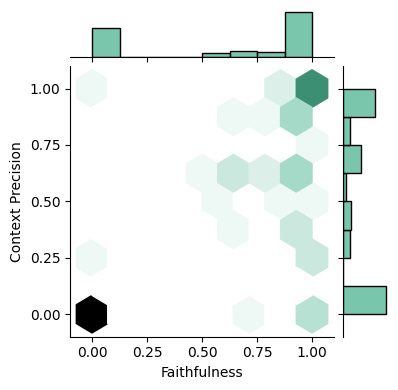

In [10]:
bins = np.linspace(0, 1, 9)
ticks = np.arange(0, 1.1, 0.25)

sns.jointplot(
    data=df_v0,
    x='faithfulness',
    y='context_precision',
    kind='hex',
    joint_kws={'gridsize': 7,
            'vmin': 0,
            'vmax': 20,
            'extent': [0, 1, 0, 1]},
    marginal_kws={'bins': bins},
    height=4,
    color="#4CB391"
)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel("Faithfulness")
plt.ylabel("Context Precision")
plt.show()

This plot shows a very high-density dark region where context precision and faithfulness are both ~0. In other words, this is where the pipeline is unable to retrieve relevant information from the document, so it hallucinates responses.

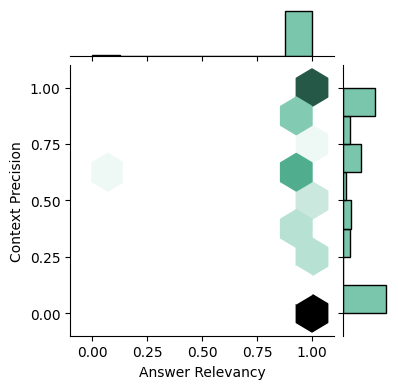

In [11]:
sns.jointplot(
    data=df_v0,
    x='answer_relevancy',
    y='context_precision',
    kind='hex',
    joint_kws={'gridsize': 7,
            'vmin': 0,
            'vmax': 20,
            'extent': [0, 1, 0, 1]},
    marginal_kws={'bins': bins},
    height=4,
    color="#4CB391"
)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel("Answer Relevancy")
plt.ylabel("Context Precision")
plt.show()

This plot paints a similar picture, demonstrating that answer relevancy and context precision are almost entirely uncorrelated. This means that the system delivers highly relevant answers, even when the retrieved context is not relevant. This is a bad sign, as it again indicates that the system is hallucinating in its responses.

Based on these findings, even in the absence of any ground truth labels, we can see that the pipeline is hallucinating in its responses when it is unable to retrieve relevant information from the document.


### Optimized RAG Pipeline 🚀

To improve the pipeline, we took the following steps:

1. **Query Revisor**: We created a custom component that revises the user query into a more suitable search query to retrieve relevant information from the document.    
2. **Prompt Optimization**: The prompt and system prompt for the LLM that generates the response were updated with much more explicit instructions to be faithful to the retrieved context.

To give you a sense of the structure of the pipeline, take a look at the pipeline preview below:

In [27]:
from IPython.display import IFrame
IFrame('https://instill.tech/george_strong/pipelines/auto-evaluative-rag/preview', width=1000, height=900)

Let's now repeat the same process of calling the new pipeline on the same set of questions and extracting the evaluation metrics.

In [28]:
results_v1 = process_all_questions(
    questions,
    pipeline_id="auto-evaluative-rag",
    top_k=top_k
)

Processing questions: 100%|██████████| 71/71 [03:35<00:00,  3.03s/it]


As before, we can extract the evaluation metrics from the pipeline run logs and generate simple statistics and plots to analyze its performance.

In [12]:
runs_v1 = MessageToDict(
    pipeline.list_pipeline_runs(
        namespace_id=namespace_id,
        pipeline_id="auto-evaluative-rag",
        total_size=len(questions)
    )
)['pipelineRuns']

In [13]:
# Extract metrics from all runs
metrics_v1 = []
for run in runs_v1:
    metrics = run['outputs'][0]['evaluation-metrics']
    metrics_v1.append({
        'context_precision': metrics['contextPrecision'],
        'answer_relevancy': metrics['answerRelevancy'],
        'faithfulness': metrics['faithfulness']
    })

# Convert to DataFrame for easier analysis
df_v1 = pd.DataFrame(metrics_v1)

# Basic statistics
print("Metrics Statistics:")
print(df_v1.describe())

Metrics Statistics:
       context_precision  answer_relevancy  faithfulness
count          71.000000         71.000000     71.000000
mean            0.457485          0.750047      0.817398
std             0.395614          0.409936      0.289929
min             0.000000          0.000000      0.000000
25%             0.000000          0.500000      0.668333
50%             0.500000          1.000000      1.000000
75%             0.857000          1.000000      1.000000
max             1.000000          1.000000      1.000000


While mean answer relevancy has decreased, mean faithfulness has increased, indicating that the number of hallucinations has been reduced 🎉!

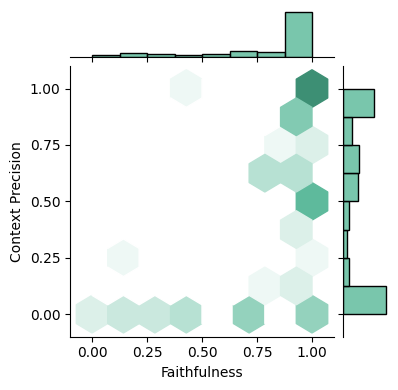

In [14]:
sns.jointplot(
    data=df_v1,
    x='faithfulness',
    y='context_precision',
    kind='hex',
    joint_kws={'gridsize': 7,
            'vmin': 0,
            'vmax': 20,
            'extent': [0, 1, 0, 1]},
    marginal_kws={'bins': bins},
    height=4,
    color="#4CB391"
)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel("Faithfulness")
plt.ylabel("Context Precision")
plt.show()

The high-density region where context precision and faithfulness were both ~0 has been eradicated. While context precision is roughly the same, this suggests that the pipeline response is now much more faithful to the retrieved context.

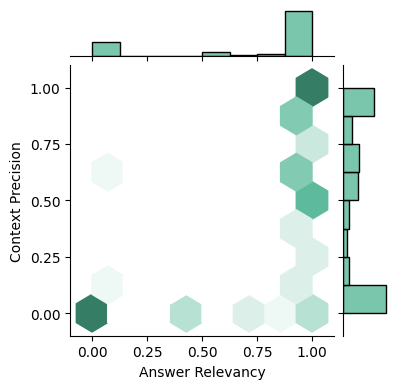

In [15]:
sns.jointplot(
    data=df_v1,
    x='answer_relevancy',
    y='context_precision',
    kind='hex',
    joint_kws={'gridsize': 7,
            'vmin': 0,
            'vmax': 20,
            'extent': [0, 1, 0, 1]},
    marginal_kws={'bins': bins},
    height=4,
    color="#4CB391"
)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel("Answer Relevancy")
plt.ylabel("Context Precision")
plt.show()

This plot now shows a clear relationship between answer relevancy and context precision. We can observe two distinct high-density regions:
   - The top-right region where both answer relevancy and context precision are high: relevant information can be retrieved and so a highly relevant answer is given.
   - The bottom-left region where both answer relevancy and context precision are low: relevant information cannot be retrieved (probably because the query is out of scope) and so a less relevant answer is given.

This suggests that the pipeline is now able to retrieve relevant information from the document and deliver highly relevant answers.

By leveraging LLM-based evaluations, we enhanced the RAG system's ability to produce trustworthy and actionable insights, demonstrating how these metrics can significantly improve system outcomes.

In [16]:
pipeline.close()
artifact.close()

Hope you enjoyed this cookbook on RAG with LLM-based Evaluations!

Checkout our [blog](https://www.instill.tech/blog) for more tutorials and AI-related insights, and stay tuned for more notebooks coming soon! 🚀